File not found at -f. Using synthetic demo series instead.
Synthetic series length: 144


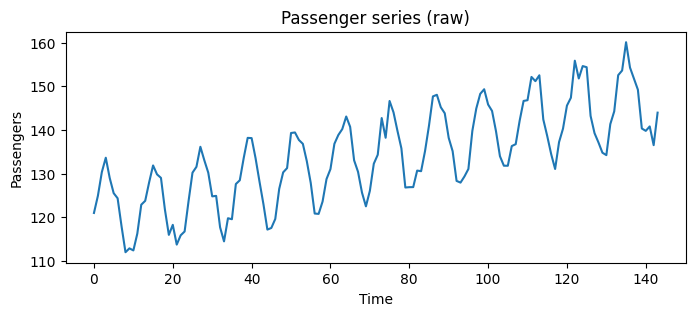

trainX shape: (98, 10, 1), trainY shape: (98, 1)
testX shape:  (36, 10, 1), testY shape:  (36, 1)
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0922 - val_loss: 0.1705
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0464 - val_loss: 0.0700
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0308 - val_loss: 0.0292
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0303 - val_loss: 0.0242
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0330 - val_loss: 0.0270
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0295 - val_loss: 0.0305
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0276 - val_loss: 0.0311
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0318 - val_loss: 0.0296
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0267 - val_loss: 0.0292
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0242 - val_loss: 0.0272


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 20)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,345 (20.88 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,564 (13.93 KB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Train RMSE: 7.97
Test RMSE:  9.43


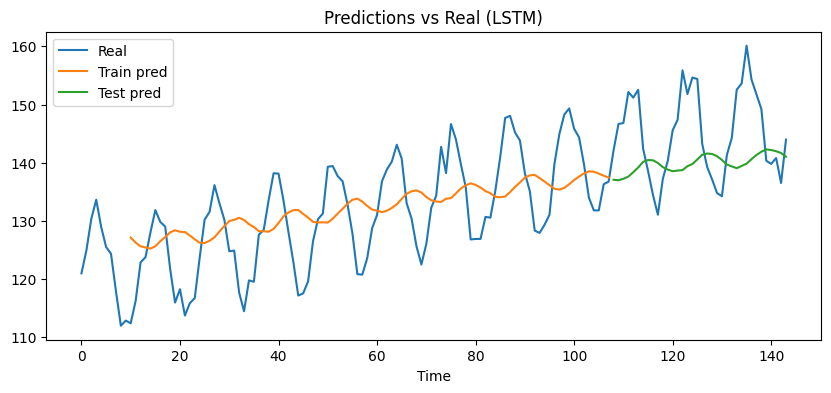

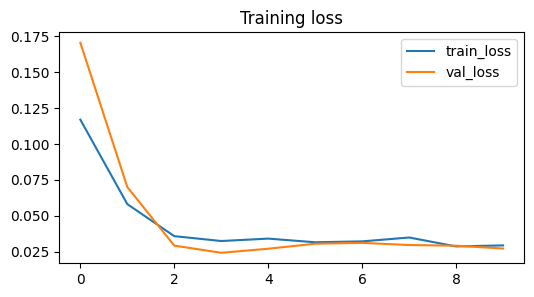

In [ ]:

"""
LSTM
"""

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sys


SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

TIME_STEPS = 10
EPOCHS = 30
BATCH_SIZE = 8
LSTM_UNITS = 20

def safe_load_series(csv_path):
    """
    Load passenger series from CSV path. If the file is not found,
    generate a synthetic demo series so the script runs in Colab without files.
    Expects passenger counts in the 2nd column (index 1), similar to the original dataset.
    """
    p = Path(csv_path)
    if p.exists():
        try:
            df = pd.read_csv(p, engine="python", skipfooter=5)
        except Exception:
            df = pd.read_csv(p)
        series = df.iloc[:, 1].astype("float32").values
        print(f"Loaded {len(series)} rows from {p}")
    else:
        print(f"File not found at {p}. Using synthetic demo series instead.")
        t = np.arange(0, 144)
        seasonal = 20 + 10 * np.sin(2 * np.pi * t / 12)
        trend = 0.2 * t
        noise = np.random.RandomState(SEED).normal(scale=2.0, size=len(t))
        series = (100 + trend + seasonal + noise).astype("float32")
        print(f"Synthetic series length: {len(series)}")
    return series

def create_sequences(data_array, time_steps):

    X, y = [], []
    for i in range(len(data_array) - time_steps):
        X.append(data_array[i : i + time_steps])
        y.append(data_array[i + time_steps])
    X = np.array(X).reshape(-1, time_steps, 1)  # features = 1
    y = np.array(y)
    return X, y


def main(csv_path=CSV_PATH):
    series = safe_load_series(csv_path)

    plt.figure(figsize=(8, 3))
    plt.plot(series)
    plt.title("Passenger series (raw)")
    plt.xlabel("Time")
    plt.ylabel("Passengers")
    plt.show()


    data = series.reshape(-1, 1).astype("float32")
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)


    train_size = int(len(data_scaled) * 0.75)
    train_scaled = data_scaled[:train_size]
    test_scaled = data_scaled[train_size - TIME_STEPS :]


    trainX, trainY = create_sequences(train_scaled, TIME_STEPS)
    testX, testY = create_sequences(test_scaled, TIME_STEPS)

    print(f"trainX shape: {trainX.shape}, trainY shape: {trainY.shape}")
    print(f"testX shape:  {testX.shape}, testY shape:  {testY.shape}")


    model = Sequential([
        LSTM(LSTM_UNITS, input_shape=(TIME_STEPS, 1)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")

    # Early stopping keeps runs short in Colab/Spyder when validation stops improving
    es = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)

    history = model.fit(
        trainX, trainY,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=False,
        callbacks=[es],
        verbose=1
    )

    model.summary()


    train_pred = model.predict(trainX)
    test_pred = model.predict(testX)


    train_pred_inv = scaler.inverse_transform(train_pred)
    trainY_inv = scaler.inverse_transform(trainY.reshape(-1, 1))
    test_pred_inv = scaler.inverse_transform(test_pred)
    testY_inv = scaler.inverse_transform(testY.reshape(-1, 1))


    train_rmse = math.sqrt(mean_squared_error(trainY_inv[:, 0], train_pred_inv[:, 0]))
    test_rmse = math.sqrt(mean_squared_error(testY_inv[:, 0], test_pred_inv[:, 0]))
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Test RMSE:  {test_rmse:.2f}")

    full = scaler.inverse_transform(data_scaled).flatten()
    train_plot = np.full_like(full, np.nan, dtype=float)
    test_plot = np.full_like(full, np.nan, dtype=float)

    train_plot[TIME_STEPS : TIME_STEPS + len(train_pred_inv)] = train_pred_inv.flatten()
    test_start = train_size
    test_plot[test_start : test_start + len(test_pred_inv)] = test_pred_inv.flatten()

    plt.figure(figsize=(10, 4))
    plt.plot(full, label="Real")
    plt.plot(train_plot, label="Train pred")
    plt.plot(test_plot, label="Test pred")
    plt.legend()
    plt.title("Predictions vs Real (LSTM)")
    plt.xlabel("Time")
    plt.show()


    plt.figure(figsize=(6, 3))
    plt.plot(history.history["loss"], label="train_loss")
    if "val_loss" in history.history:
        plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Training loss")
    plt.show()

if __name__ == "__main__":

    if len(sys.argv) > 1:
        CSV_PATH = sys.argv[1]
    main(CSV_PATH)
